In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


# Data loading and first look

In [3]:
#loading the dataset
df = pd.read_csv('apple_quality.csv')
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [5]:
#checking the types of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


# Clean data

In [11]:
# functions to verify if a string is a float
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

# seach for the value of Acidity column that is not a float64 that transforms the acidity column to object type
df[df['Acidity'].apply(lambda x: not isfloat(x))]


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


In [12]:
# Drop str line that Acidity is a str and not a float
df = df.drop([4000])
df['Acidity'] = df['Acidity'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   object 
dtypes: float64(8), object(1)
memory usage: 281.4+ KB


In [13]:
# Transform the Quality column to binary (good=1, bad=0)
df['Quality'] = df['Quality'].map({'good':1, 'bad':0})
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1


In [14]:
# Drop A_id column
df = df.drop(['A_id'], axis=1)
df.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1


# Exploratory data analysis

In [17]:
df[['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']].describe()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277,0.076877
std,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427,2.110270
min,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599,-7.010538
25%,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677,-1.377424
50%,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445,0.022609
75%,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212,1.510493
max,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837,7.404736


1    2004
0    1996
Name: Quality, dtype: int64


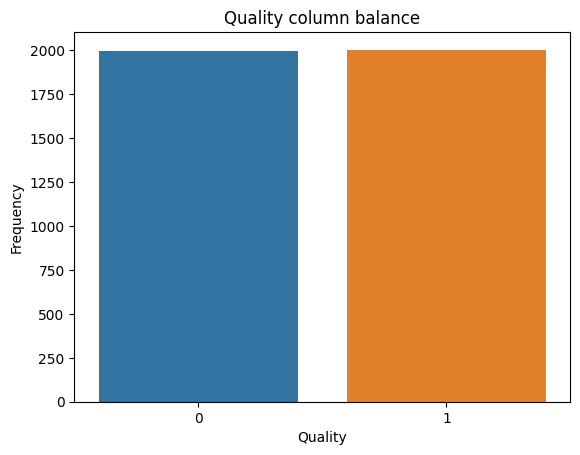

In [15]:
# Verify the balance of the Quality column
print(df['Quality'].value_counts())

#plot a bar graph to visualize the balance of the Quality column
sns.barplot(x=df['Quality'].value_counts().index, y=df['Quality'].value_counts().values)
plt.title('Quality column balance')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()

### The boxplot shows that the distribution of the independent variables segmented by 'y' is similar. However, it will be necessary to evaluate the correlation, using a heatmap, and the multicollinearity of the data using the VIF to select the independent variables.

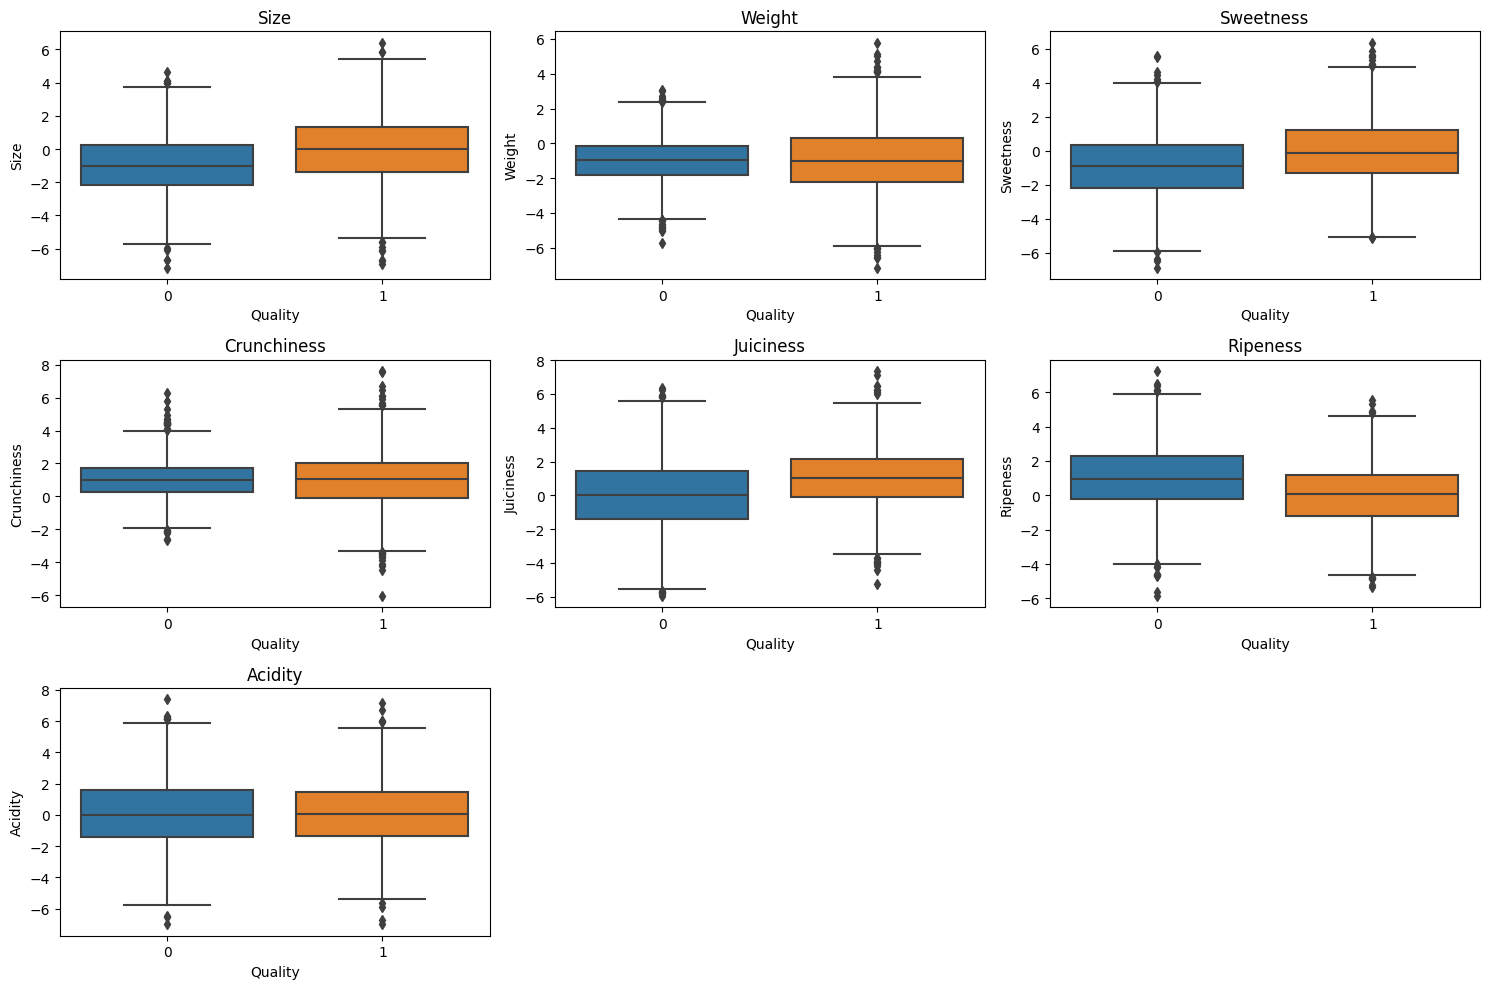

In [20]:
# Plot a boxplot to visualize the distribution of the independent variables
X = df.drop(['Quality'], axis=1)
y = df['Quality']

plt.figure(figsize=(15, 10))
for i, col in enumerate(X.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=X[col], x=y)
    plt.title(col)
plt.tight_layout()
plt.show()

## Multicoliearity check

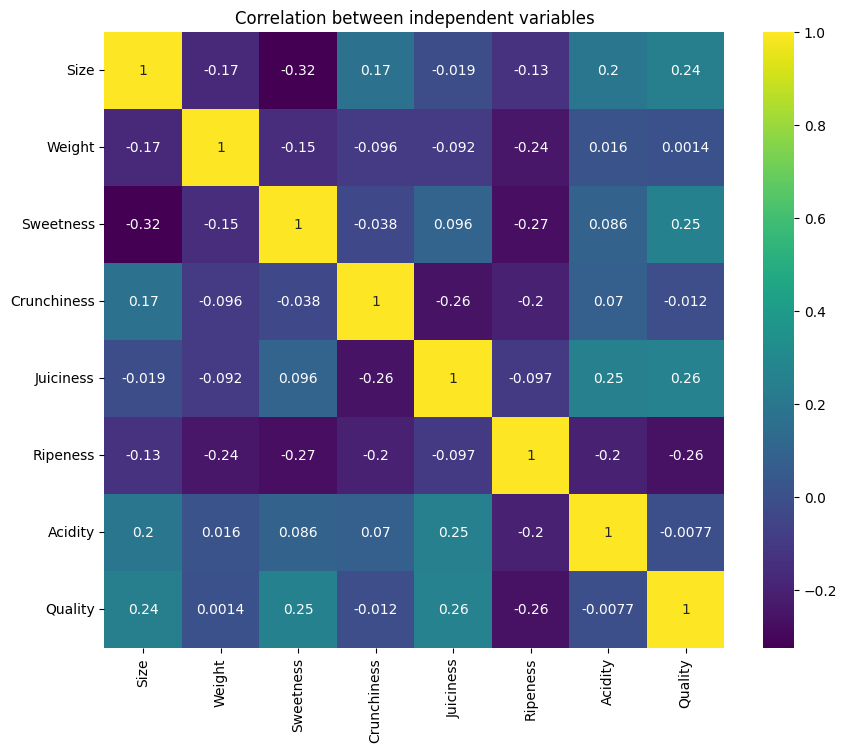

In [21]:
# plot a heatmap to visualize the correlation between the independent variables
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis')
plt.title('Correlation between independent variables')
plt.show()

In [22]:
# import VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [23]:
# check for multicollinearity
X_const = add_constant(X)
vif = pd.DataFrame()
vif['variables'] = X_const.columns
vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
vif

,variables,VIF
0,const,2.498135
1,Size,1.413203
2,Weight,1.347796
3,Sweetness,1.476987
4,Crunchiness,1.218052
5,Juiciness,1.219475
6,Ripeness,1.477834
7,Acidity,1.172115


### As the coefficients for the VIF are approximately 1, we can conclude that the independent variables are not correlated and there is no multicollinearity for the independent variables.

# Preprocessing

### In the description of the data, it was stated that the data has already been standardized, so there is no need to standardize it. We will therefore move on to other pre-processing steps.

In [27]:
# Split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

# Testing models

In [40]:
# creating a function for model evaluation
def model_evaluation(model, X_train, X_test, y_train, y_test):
    kf = KFold(n_splits=5, shuffle=True, random_state=40)
    cv = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Cross validation accuracy:', cv.mean(), end='\n\n')
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred), end='\n\n')
    print('Classification Report:\n', classification_report(y_test, y_pred))

## Logistic Regression

In [42]:
log_reg = LogisticRegression()
model_evaluation(log_reg, X_train, X_test, y_train, y_test)


Cross validation accuracy: 0.7474999999999999

Confusion Matrix:
 [[446 157]
 [144 453]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75       603
           1       0.74      0.76      0.75       597

    accuracy                           0.75      1200
   macro avg       0.75      0.75      0.75      1200
weighted avg       0.75      0.75      0.75      1200



## SVC

In [43]:
svc = SVC()
model_evaluation(svc, X_train, X_test, y_train, y_test)

Cross validation accuracy: 0.8828571428571429

Confusion Matrix:
 [[526  77]
 [ 61 536]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88       603
           1       0.87      0.90      0.89       597

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.88      1200
weighted avg       0.89      0.89      0.88      1200



## Random Forest

In [44]:
random_forest = RandomForestClassifier()
model_evaluation(random_forest, X_train, X_test, y_train, y_test)

Cross validation accuracy: 0.8835714285714286

Confusion Matrix:
 [[527  76]
 [ 68 529]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88       603
           1       0.87      0.89      0.88       597

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.88      0.88      0.88      1200



## XGBoost Classifier

In [45]:
xgb_classifier = XGBClassifier()
model_evaluation(xgb_classifier, X_train, X_test, y_train, y_test)

Cross validation accuracy: 0.8839285714285715

Confusion Matrix:
 [[538  65]
 [ 64 533]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       603
           1       0.89      0.89      0.89       597

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200



## LightGBM Classifier

In [47]:
lgbm_classifier = LGBMClassifier(verbose=-1)
model_evaluation(lgbm_classifier, X_train, X_test, y_train, y_test)



Cross validation accuracy: 0.8835714285714286

Confusion Matrix:
 [[537  66]
 [ 59 538]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90       603
           1       0.89      0.90      0.90       597

    accuracy                           0.90      1200
   macro avg       0.90      0.90      0.90      1200
weighted avg       0.90      0.90      0.90      1200



### The only model with a performance below 80% was logistic regression. The SVC, Random Forest, XGB Classifier and LGBM Classifier models obtained similar results, but as the LGBM Classifier has better processing performance, we will use it to adjust our final model.

# Adjusting the final model

In [49]:
# parameter tuning for LGBMClassifier

kf = KFold(n_splits=5, shuffle=True, random_state=40)
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7, 8]
}

grid_search = GridSearchCV(lgbm_classifier, param_grid, cv=kf, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

best_params = grid_search.best_params_

{'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 100}


In [57]:
# fit the model with the best parameters
lgbm_classifier = LGBMClassifier(**best_params, verbose=-1)
lgbm_classifier.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.2, verbose=-1)

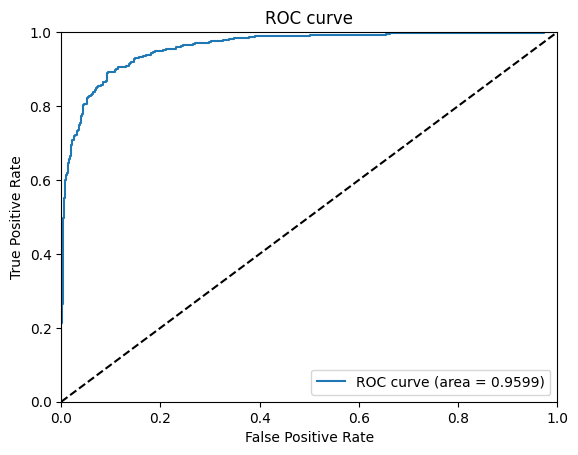

In [59]:
# ROC curve for the lgbm_classifier model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_scores = lgbm_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.plot(fpr, tpr, label=f"ROC curve (area = {round(auc(fpr, tpr),4)})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

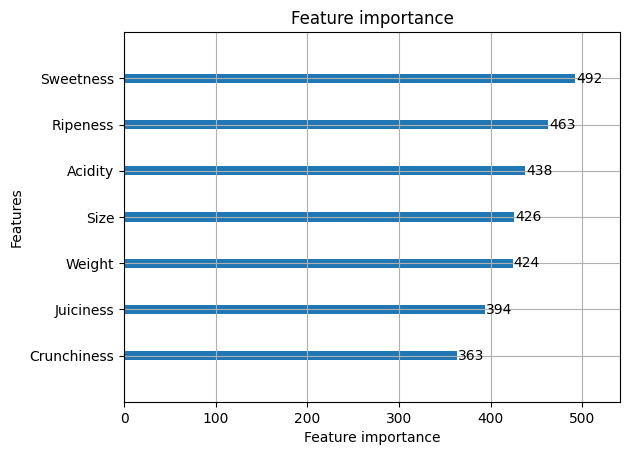

In [81]:
import lightgbm as lgb
lgb.plot_importance(lgbm_classifier, importance_type='auto')
plt.show()

# Conclusions

### An ROC AUC (Area Under the Receiver Operating Characteristic Curve) of 0.96 indicates that the classification model has an excellent ability to distinguish between positive and negative classes. Therefore, the LGBM Classifier model with the best parameters performs very well for classifying apple quality, showing a strong ability to discriminate between classes. This suggests that the model is highly effective for the specific problem being addressed.